<a href="https://colab.research.google.com/github/DataBaeDev/MPG-Analysis/blob/main/MPG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question

Can a vehicle's attributes (such as weight, cylinders, displacement, horsepower, etc.) be used to predict the vehicle's miles per gallon?

## Import libraries & data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import pickle

In [ ]:
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
car_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', na_values = ['NA', '?'], names = columns, delim_whitespace=True)

In [ ]:
car_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Configure Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

sns.set()

## Exploratory Data Analysis

In [ ]:
car_df.shape

(398, 9)

In [ ]:
car_df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   year          398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


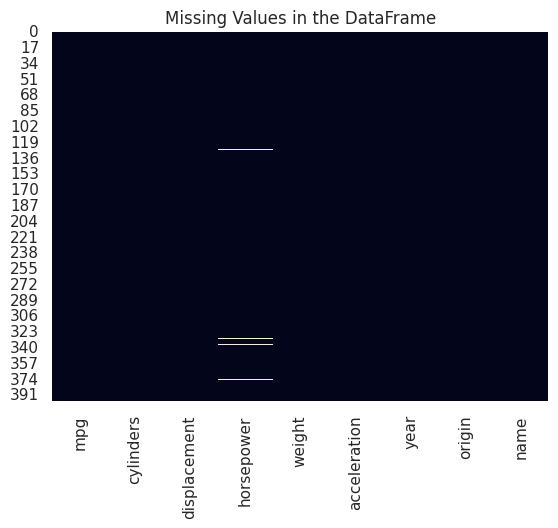

In [ ]:
sns.heatmap(car_df.isnull(),cbar=False)
plt.title("Missing Values in the DataFrame");

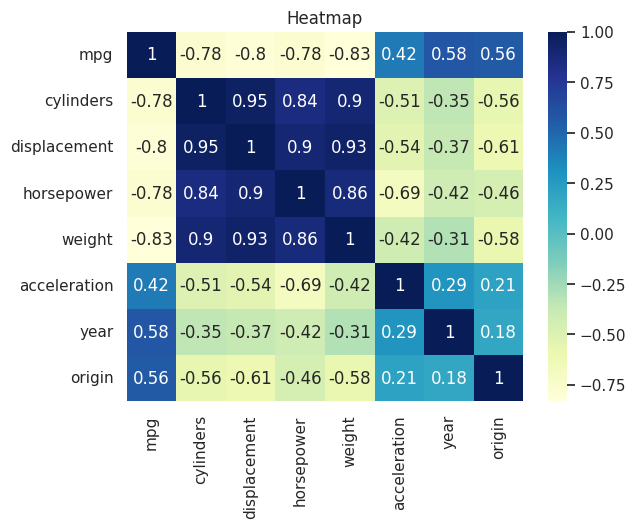

In [ ]:
sns.heatmap(car_df.drop("name", axis=1).corr(), cmap="YlGnBu", annot=True).set(title="Heatmap");

In [ ]:
print(f"There are {car_df.name.nunique()} unique values for the name feature.")

There are 305 unique values for the name feature.


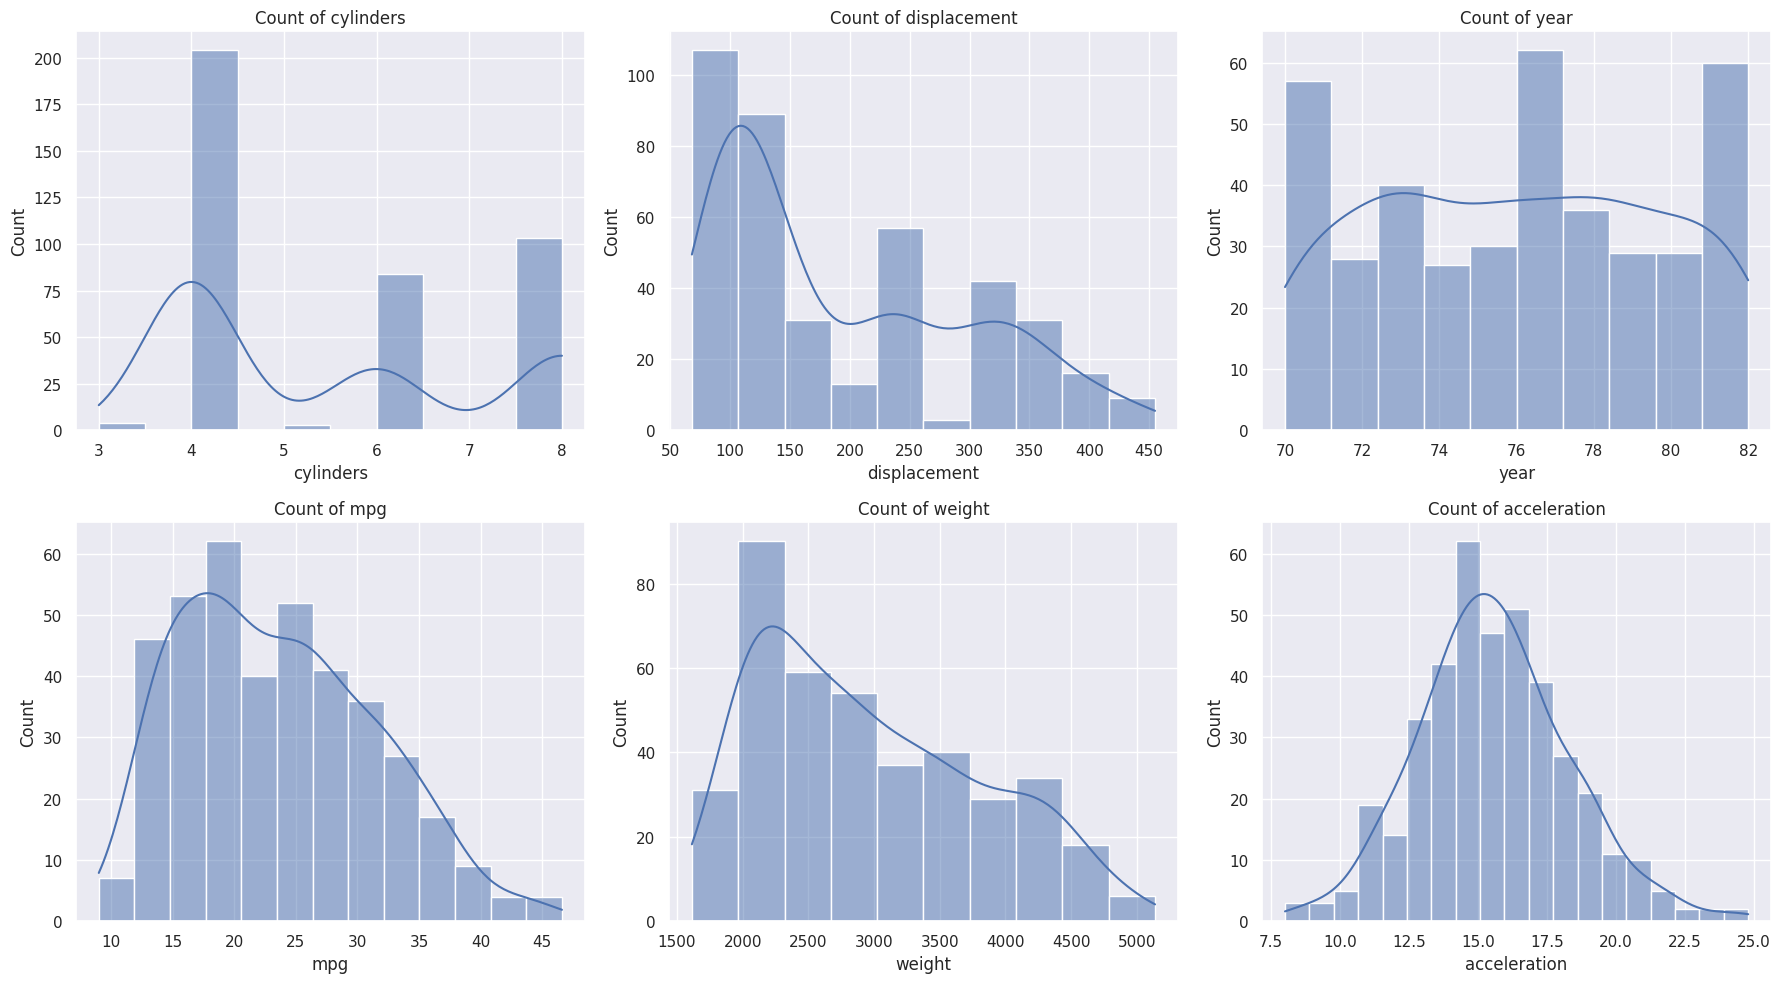

In [ ]:
# Columns to be visualized
cols = ['cylinders', 'displacement', 'year', 'mpg','weight', 'acceleration']

# Create a figure containing 6 subplots(2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loop through the columns and generate plots
for idx, col in enumerate(cols):

    #set the indices used for placing each visualization
    row = idx // 3
    col_idx = idx % 3

    sns.histplot(car_df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Count of {col}')

plt.tight_layout()
plt.show()

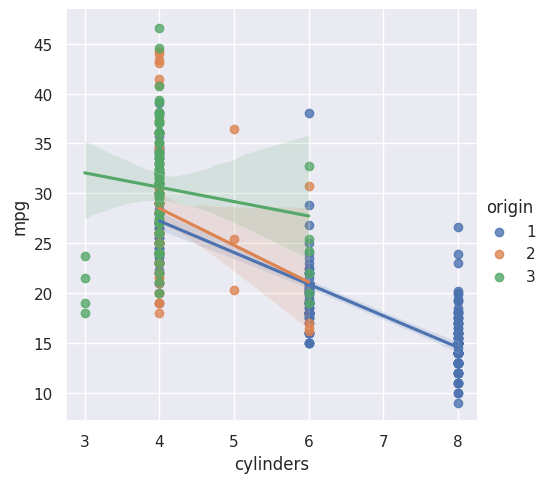

In [ ]:
#Visualizating the relationship between cylinders and mpg
sns.lmplot(data = car_df, x = "cylinders", y = 'mpg', hue="origin");

## Data Cleaning and Manipulation

In [ ]:
#drop the unneeded column
car_df = car_df.drop("name", axis=1)

In [ ]:
# Based on the heatmap above, horsepower is highly correlated with the number of cylinders
# Find the average horsepower by number of cylinders
avg_horsepower = car_df.groupby('cylinders')['horsepower'].mean()
print(avg_horsepower)

cylinders
3     99.250000
4     78.281407
5     82.333333
6    101.506024
8    158.300971
Name: horsepower, dtype: float64


In [ ]:
# Fill missing horsepower values using a lambda function
car_df['horsepower'] = car_df.apply(lambda row: avg_horsepower[row['cylinders']] if pd.isnull(row['horsepower']) else row['horsepower'], axis=1)

In [ ]:
#double check to ensure that there are no more null values
car_df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64

## Conceptualize the problem

How well can can the combination of the following features predict the vehicle's mpg: <br>'cylinders', 'displacement', 'year', 'origin', 'mpg','weight', 'acceleration'?

What model(s) work the best?

## Split the Dataset

In [ ]:
#Select features and target
X = car_df.drop("mpg", axis=1).values
y = car_df['mpg'].values

In [ ]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 22)

In [ ]:
print(f'The shape of the data is: \nx_train: \t{X_train.shape} \nx_test: \t{X_test.shape} \ny_train: \t{y_train.shape} \ny_test: \t{y_test.shape}')

The shape of the data is: 
x_train: 	(318, 7) 
x_test: 	(80, 7) 
y_train: 	(318,) 
y_test: 	(80,)


## Select, Train, and Save Models

In [ ]:
model_dict = {
    "Linear_Regression_Model" : LinearRegression(),
    "Decision_Tree_Model" : DecisionTreeRegressor(),
    "Random_Forest_Model" : RandomForestRegressor(),
    "XGB_Regressor_Model" : XGBRegressor()
  }

In [ ]:
for model in model_dict:
  model_dict[model].fit(X_train, y_train)
  score = round(model_dict[model].score(X_test, y_test)*100, 2)
  print(f'The accuracy score for the {model} is {score}%.')
  pickle.dump(model_dict[model], open(f'/content/drive/MyDrive/Predictive Analytics/MPG Analysis/{model}_.pkl','wb'))

The accuracy score for the Linear_Regression_Model is 77.93%.
The accuracy score for the Decision_Tree_Model is 76.49%.
The accuracy score for the Random_Forest_Model is 86.3%.
The accuracy score for the XGB_Regressor_Model is 82.5%.


## Predictions

In [ ]:
#select a random record from the Test Group

#initiate a NumPy random number generator
rng = np.random.default_rng()
rand_num = rng.integers(80, size=1)

test_record = X_test[rand_num]

In [ ]:
#Print the values for the test record
param_list = car_df.drop("mpg", axis=1).columns

print("Values for the test record")
for num in range(len(param_list)):
  print(f"{param_list[num]}: ", test_record[0, num])

Values for the test record
cylinders:  8.0
displacement:  350.0
horsepower:  145.0
weight:  4055.0
acceleration:  12.0
year:  76.0
origin:  1.0


In [ ]:
#print the predictions for each model
for model in model_dict:
      prediction =   model_dict[model].predict(test_record)
      print(f'The model {model} predicts an mpg of {round(float(prediction[0]), 2)}')

The model Linear_Regression_Model predicts an mpg of 16.53
The model Decision_Tree_Model predicts an mpg of 14.5
The model Random_Forest_Model predicts an mpg of 15.91
The model XGB_Regressor_Model predicts an mpg of 15.74


In [ ]:
print("The actual mpg for this vehicle is ", y_test[rand_num], " mpg.")

The actual mpg for this vehicle is  [13.]  mpg.


## Findings

After running the models several times, I found that the accuracy rates fluctuate between 71% - 89%. The Random Forest Model consistently scores the best, usually 3% - 5% higher than the next best model.

Overall, it seems that vehicle attributes (such as   weight, cylinders, displacement, horsepower, etc.) can be used to predict a vehicle's miles per gallon fairly accurately.